In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import odeint, solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage.filters import laplace, convolve1d
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

In [139]:
def gaussian(x):
    y = np.exp(-0.5 * x ** 2) / sqrt(2 * np.pi)
    return y


def cdf_gaussian(x):
    y = 0.5 * (1 + erf(x / sqrt(2)))
    return y


def trunc_gaussian(x, mu, sigma, a=0, b=1):
    xi = (x - mu) / sigma
    beta = (b - mu) / sigma
    alpha = (a - mu) / sigma
    y = gaussian(xi) / sigma
    y /= cdf_gaussian(beta) - cdf_gaussian(alpha)
    return y


def dydt_int(t, y, alpha, r_d, var, kernel):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    dy = np.empty_like(y)
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)
        
    dy = np.trapz(alpha * y * kernel, dx=dalpha, axis=-1)

    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy


# first order approximation
def dydt(t, y, alpha, r_d, v):
    y[y<0] = 0
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    # dy = alpharho + v * laplace(alpharho) / da**2
    dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

# def dydt_allee(t, y, alpha, r_d, v, K):
#     da = alpha[1] - alpha[0]
#     rho = np.trapz(y, dx=da)
#     alpharho = alpha * y
#     dy = alpharho * (y - 1 / K) + v * laplace(alpharho)
#     dy *= 1 - rho
#     dy -= r_d * y
#     return dy

# analytical predictions for bulk
def meanfitness(t, r_b, r_d, m, v0):
    """
    mean fitness over time in the bulk, given initial mean birth rate r_b, initial variance v0, mutationrate m
    """
    return np.sqrt(r_d**2 * m * t**2 + 2 * r_d * (v0+m) * t + r_b**2)


In [140]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.02
r_b = 0.1
var = 0.005**2
tmax = 5000
Da = var / 2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=101)
trunc_gauss_kernel = np.array([trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min - alpha, b=a_max - alpha) for a in alpha])
K = 1000
y0 = np.zeros_like(alpha)
y0[np.argwhere(alpha==r_b)] = dens0 / dalpha

In [141]:
sol = solve_ivp(dydt_int, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, var, trunc_gauss_kernel), method='DOP853').y.T
sol2 = solve_ivp(dydt, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, Da), method='DOP853')
print(sol2.message)
sol2 = sol2.y.T

The solver successfully reached the end of the integration interval.


In [142]:
# sol3 = solve_ivp(dydt_allee, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, Da, K), method='DOP853').y.T

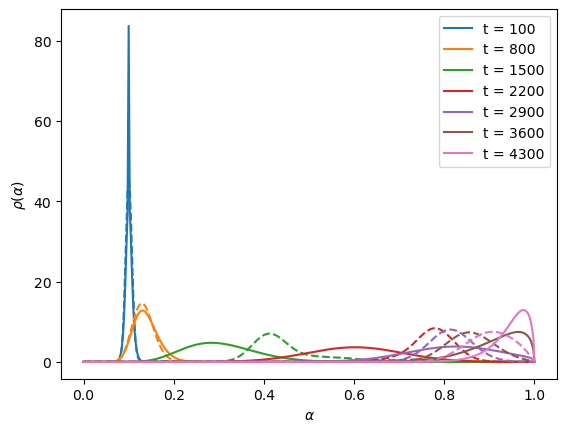

In [143]:
for t in np.linspace(2, len(ts), 7, dtype=int, endpoint=False):
    p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
    plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.plot(alpha, sol3[t], '-.', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.legend()

In [59]:
lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=K-2)
lgca.timeevo(timesteps=tmax, record=True)

Family relationships not tracked.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:19<00:00, 63.05it/s]


In [60]:
# lgca2 = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
#                 r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=9998)
# lgca2.timeevo(timesteps=tmax, record=True)

In [144]:
# calc observables
rhoint = np.trapz(sol, dx=dalpha)
rholoc = np.trapz(sol2, dx=dalpha)
meanalphaint = np.trapz(sol * alpha, dx=dalpha) / rhoint
meanalphaloc = np.trapz(sol2 * alpha, dx=dalpha) / rholoc
meanalphaana = meanfitness(ts, r_b, r_d, var, 0)
rhoana = 1 - r_d / meanalphaana

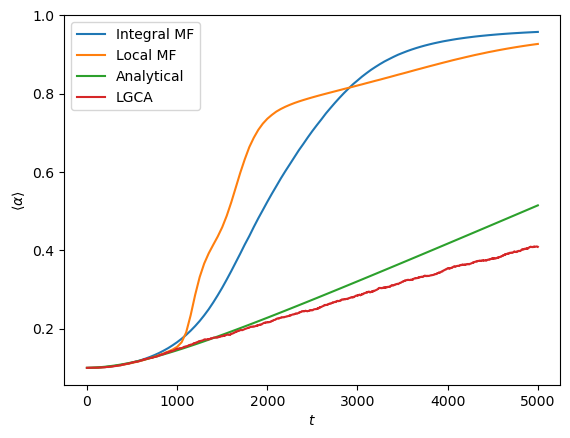

In [145]:
plt.plot(ts, meanalphaint, label='Integral MF')
plt.plot(ts,  meanalphaloc, label='Local MF')
plt.plot(ts, meanalphaana, label='Analytical')
lgca.plot_prop_timecourse(label='LGCA')
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.legend()
# plt.loglog()

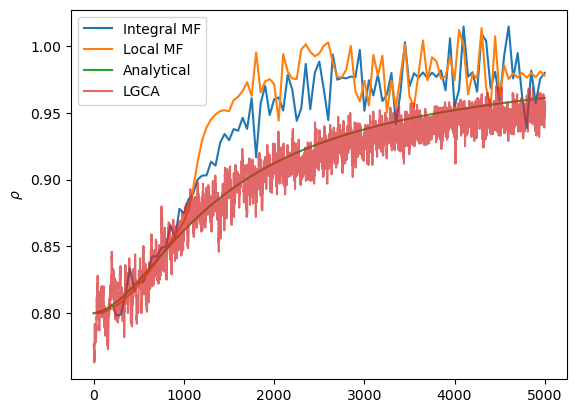

In [146]:
plt.plot(ts, rhoint, label='Integral MF')
plt.plot(ts, rholoc, label='Local MF')
plt.plot(ts, rhoana, label='Analytical')
plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.K, label='LGCA', alpha=.7)
plt.title('')
plt.ylabel('$\\rho$')
plt.legend()

In [147]:
var_ana = r_d * var * ts

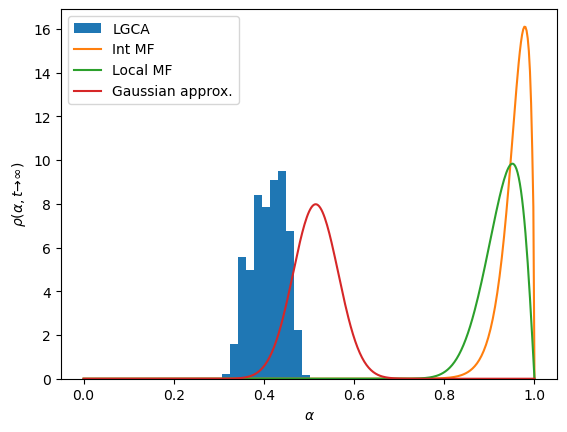

In [148]:
bins = int(np.ceil(np.log2(lgca.occupied.sum()))+1)
# plt.hist(np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]], bins=bins, density=True, label='LGCA')
plt.hist(lgca.get_prop(nodes=lgca.nodes[lgca.nodes > 0]), bins=bins, density=True, label='LGCA')
plt.plot(alpha, sol[-1] / sol[-1].sum() / dalpha, label='Int MF')
plt.plot(alpha, sol2[-1] / sol2[-1].sum() / dalpha, label='Local MF')
plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[-1], sqrt(var_ana[-1]), a=0, b=1), label='Gaussian approx.')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha, t \\to \\infty)$')
plt.legend()

In [14]:
def dydt_spatial(t, y, alpha, dx, r_d, v, D):
    y = y.reshape((-1, len(alpha)))
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da, axis=-1)
    alpharho = alpha * y
    dy = alpharho + v * convolve1d(alpharho, [1, -2, 1], axis=-1, mode='mirror')
    dy[:, -1] = alpharho[:, -1] - v * da * (y[:, -2] + alpha[-2] * (y[:, -1] - y[:, -3]) / 2 / da)  # zero flux boundary conditions

    dy *= (1 - rho[..., None])
    dy -= r_d * y
    dy += convolve1d(y, [1, -2, 1], axis=0, mode='mirror') / dx**2 / 2 * D
    return dy.flatten()

In [15]:
nx = 300
xmax = 1000
x, dx = np.linspace(0, xmax, nx, retstep=True, endpoint=False)
da = dalpha
p_m = .01
v = p_m * var / da**2 / 2
D = .02
tmax = 2000
dens0 = 1 - r_d / r_b
# dens0 = 0.01
ts, dt = np.linspace(0, tmax, num=1001, retstep=True)
ts = np.arange(tmax+1)
dt = 1

In [16]:
y0 = np.zeros((nx, na))
y0[0, np.argwhere(alpha==r_b)] = dens0 / da
solspatial = solve_ivp(dydt_spatial, (0, tmax), y0.flatten(), t_eval=ts, args=(alpha, dx, r_d, v, D))

In [17]:
solspatial.message

'The solver successfully reached the end of the integration interval.'

In [18]:
y = solspatial.y.reshape((nx, na, len(solspatial.t)))
rhotot = np.trapz(y, dx=da, axis=1)
meanalpha = np.divide(np.trapz(alpha[None, ..., None] * y, dx=da, axis=1), rhotot, where=rhotot>.01, out=np.zeros_like(rhotot))
rhoalpha = np.trapz(y, dx=dx, axis=0) / rhotot.sum(0)
meanalphatot = np.trapz(np.trapz(alpha[None, ..., None] * y, dx=da, axis=1), dx=dx, axis=0) / np.trapz(rhotot, dx=dx, axis=0)

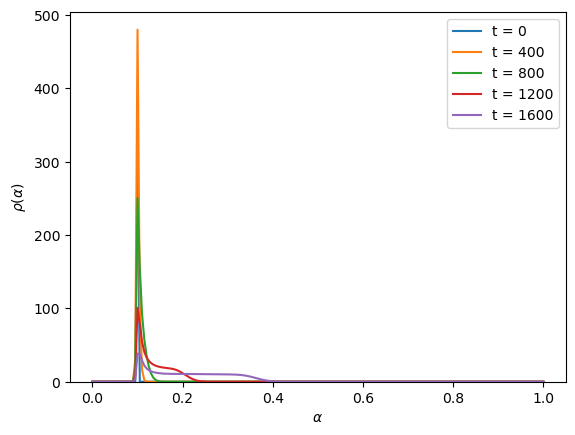

In [19]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

Text(0, 0.5, '$\\Psi (x)$')

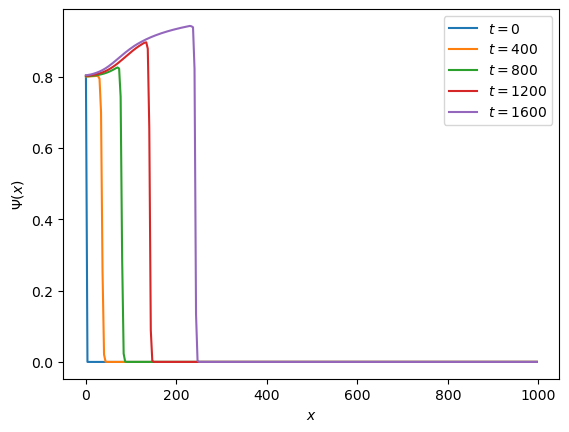

In [20]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    plt.plot(x, rhotot[..., t], label='$t = {:n}$'.format(ts[t]))
    
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')

Text(0, 0.5, '$\\langle\\alpha\\rangle (x)$')

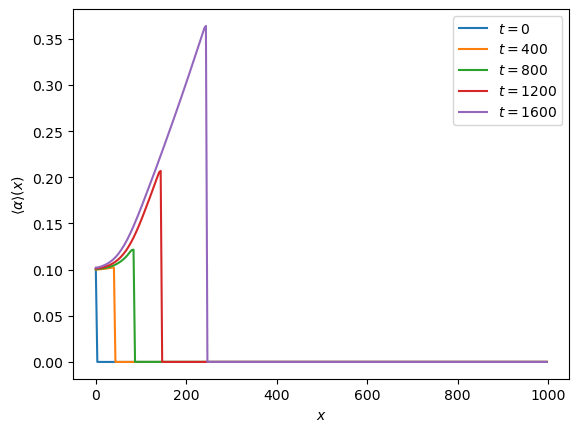

In [21]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    plt.plot(x, meanalpha[..., t], label='$t = {:n}$'.format(ts[t]))
    
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\\langle\\alpha\\rangle (x)$')

In [22]:
def meanalphaana(t, alpha0, p_m, var):
    return alpha0 * np.cosh(np.sqrt(p_m * var) * t)

In [23]:
rb_ana = meanalphaana(ts, r_b, p_m, var)

In [24]:
meanalphafront = [meanalpha[np.argmax(rhotot[:, t], axis=0), t] for t in range(len(ts))]

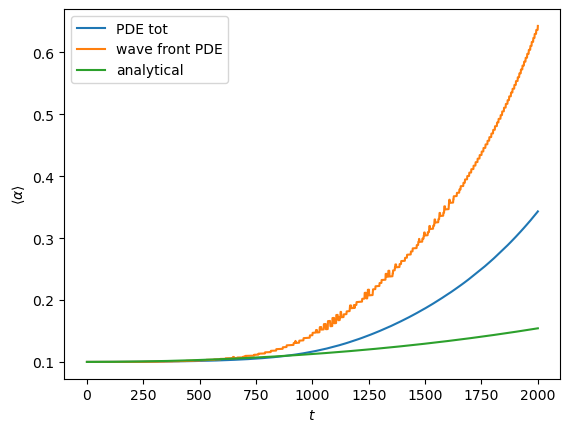

In [25]:
plt.plot(ts, meanalphatot, label='PDE tot')
plt.plot(ts, meanalphafront, label='wave front PDE')
plt.plot(ts, rb_ana, label='analytical')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.xlabel('$t$')
plt.legend()

In [26]:
# next: compare to cosh prediction, calc wave speed, compare wavespeed to lgca wavespeed over time!
# calculating the wave speed directly from data is very noisy. Strategy: interpolate the function, define a wave front, find the position of the wavefront
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, root

In [27]:
x.shape, rhotot.shape

((300,), (300, 2001))

In [28]:
rhointerp = [interp1d(x, rhotot[:,t]-.5, fill_value='extrapolate') for t in range(tmax)]
# wavefront = fsolve(rhointerp, xmax/2)
# frontindx = np.argmax(rhotot, axis=0)
# wavefront = x[np.argmin(np.gradient(rhotot, dx, axis=0), axis=0)]
# wavefront = x[frontindx]

# speed = np.gradient(wavefront, dt)

In [29]:
wavefront = [fsolve(rhoi, xmax/2) for rhoi in rhointerp]

C:\Users\simon\Anaconda3\envs\py38\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [31]:
plt.plot(ts, speed)
plt.plot(ts, 2 * np.sqrt(D * rb_ana))

NameError: name 'speed' is not defined

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    p = plt.plot(x, rhotot[..., t], lw=0, marker='x', label='$t = {:n}$'.format(ts[t]))
    plt.plot([wavefront[t], wavefront[t]], [0, 1], '--', color=p[0].get_color())
    
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
    plt.plot(alpha, y[frontindx[t], :, t], '--', color=pl[0].get_color()) 

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

In [ ]:
# D = b / K = 2 / K -> K = 2 / D
K = round(2/D)
nodes = np.zeros((xmax, xmax), dtype=bool)
nodes[0, ...] = 1
lgca2 = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath', std=sqrt(var),
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1000, restchannels=K-2)
lgca2.timeevo(timesteps=tmax-1, record=True)

In [ ]:
lgca2.plot_density()

In [ ]:
lgca2.nodes_t.shape

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    pl = plt.plot(alpha, rhoalpha[:, t], label='t = {:n}'.format(ts[t]))
    bins = round(np.ceil(np.log2(lgca2.dens_t[t].sum()))+1)
# plt.hist(np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]], bins=bins, density=True, label='LGCA')
    plt.hist(lgca2.get_prop(nodes=lgca2.nodes_t[t][lgca2.nodes_t[t] > 0]), bins=bins, density=True, color=pl[0].get_color())
#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.xlim(0)
plt.legend()

In [ ]:
meanalphalgca = np.empty_like(lgca2.dens_t)
for t in range(tmax+1):
    nodes = lgca2.nodes_t[t]
    meanalphalgca[t] = np.mean(lgca2.get_prop(nodes[nodes>0]))

In [ ]:
meanalphalgca = meanalphalgca[..., 0]

In [ ]:
plt.plot(ts, meanalphatot, label='PDE tot')
plt.plot(ts, rb_ana, label='analytical')
plt.plot(meanalphalgca, label='LGCA')
plt.plot(ts, meanalphafront, label='wave front PDE')
# lgca2.plot_prop_timecourse(label='LGCA')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.xlabel('$t$')
plt.legend()

In [ ]:
lgca2.dens_t.shape

In [ ]:
ts

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    p = plt.plot(x, rhotot[..., t], label='$t = {:n}$'.format(ts[t]))
    # plt.plot([wavefront[t], wavefront[t]], [0, 1], '-.', color=p[0].get_color())
    plt.plot(range(xmax), lgca2.dens_t[t]/lgca2.K, '-.', color=p[0].get_color())
    
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Psi (x)$')
plt.xlim(0, 300)

In [ ]:
for t in np.linspace(0, len(ts), 5, dtype=int, endpoint=False):
    plt.plot(x, meanalpha[..., t], label='$t = {:n}$'.format(ts[t]))
    plt.plot(
    
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\\langle\\alpha\\rangle (x)$')